# **NLP project. Fake News detection**

## **Basic imports** ##

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import common as cm
import torch
from typing import Optional
import unittest
import warnings

from transformers import DistilBertTokenizer
from transformers import DistilBertModel

/Users/Kuba/Library/Python/3.9/lib/python/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(
/Users/Kuba/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.base import ClassifierMixin
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input

In [3]:
import nltk
import re
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
nltk.download("wordnet")
nltk.download("omw-1.4")
nltk.download("punkt")
nltk.download("punkt_tab")
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package wordnet to /Users/Kuba/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/Kuba/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /Users/Kuba/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /Users/Kuba/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/Kuba/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [4]:
warnings.filterwarnings('ignore')

## **Loading datasets** ##

Datasets are in form of 'True.csv' and 'Fake.csv' files.
Although, they seem to be more less balanced (21k and 23k),
it is not very convenient to process all articles - instead
we will choose 1000 fake and 1000 real articles that will
serve as good sample. To achieve this, we will need to
utilize some functions from common.py to load, briefly
preprocess data and divide it into test and train sets.
As a result we will have training and test datasets that
are subsets of the whole dataset and without redundant features.

In [5]:
true = cm.load_data("True.csv")
true_short = cm.choose_random_part(true, 1000)
X_train_true, X_test_true, y_train_true, y_test_true = cm.divide_data_into_train_and_test(true_short, 0.2)

fake = cm.load_data("Fake.csv")
fake_short = cm.choose_random_part(fake, 1000)
X_train_fake, X_test_fake, y_train_fake, y_test_fake = cm.divide_data_into_train_and_test(fake_short, 0.2)

In [6]:
X_train = cm.merge_datasets(X_train_true, X_train_fake)
X_test = cm.merge_datasets(X_test_true, X_test_fake)
y_train = cm.merge_datasets(y_train_true, y_train_fake)
y_test = cm.merge_datasets(y_test_true, y_test_fake)

In [7]:
X_train, y_train = cm.shuffle_respectively(X_train, y_train)
X_test, y_test = cm.shuffle_respectively(X_test, y_test)

In [8]:
X_train_pre, y_train_pre = cm.clean_data(X_train, y_train)
X_test_pre, y_test_pre = cm.clean_data(X_test, y_test)

## **Preprocessing datasets** ##

Apart from clean_data() function that we defined in common.py, we have 3 methods of preprocessing the data:

1. Generate contextual word embeddings

2. Generate static word embeddings

3. Use lemmatization, stemmatization and create TF-IDF vector

Each of the above methods will be tested on several models and we
can compare which model works the best on which type of preprocessing

### **Helper functions** ###

In [9]:
def load_embeddings(path: str) -> dict[str, np.ndarray]:

    """
    Load word embeddings from a text file into a dictionary.

    Each line in the file should contain a word followed by its embedding vector components,
    separated by spaces.

    Args:
        path (str): Path to the embeddings file.

    Returns:
        dict[str, np.ndarray]: A dictionary mapping words (str) to their embedding vectors (np.ndarray).
    """
    mapping = dict()

    with open(path, 'r', encoding='utf8') as f:
        for line in f:
            line = line.strip()
            if len(line) == 0:
                continue
            splitted = line.split(" ")
            mapping[splitted[0]] = np.array(splitted[1:], dtype=float)
    return mapping


def avg_document(doc: str, embeddings: dict[str, np.ndarray]) -> np.ndarray:
    """
    Compute the average embedding vector for a document.

    The function tokenizes the document, looks up each token's embedding,
    and averages all available embeddings. If no tokens have embeddings,
    it returns a zero vector.

    Args:
        doc (str): The input document (text string).
        embeddings (dict[str, np.ndarray]): A dictionary mapping words to embedding vectors.

    Returns:
        np.ndarray: The average embedding vector for the document.
    """
    avg_emb = np.zeros_like(embeddings['italy'])
    tokens = word_tokenize(doc)
    len = 0
    for token in tokens:
        if token in embeddings.keys():
            avg_emb += embeddings[token]
            len += 1
    if len == 0:
        print('No word in glove embeddings for some article!')
        return avg_emb
    return avg_emb/len


def get_wordnet_pos(tag: str) -> str:
    """
    Map Part-of-Speech (POS) tags to WordNet POS constants.

    Args:
        tag (str): The POS tag (e.g., from nltk.pos_tag) to map to a WordNet POS constant.

    Returns:
        str: The corresponding WordNet POS constant (wordnet.ADJ, wordnet.VERB, wordnet.NOUN, or wordnet.ADV).
        Defaults to wordnet.NOUN if the tag does not match any specific category.
    """
    if tag.startswith("J"):
        return wordnet.ADJ
    elif tag.startswith("V"):
        return wordnet.VERB
    elif tag.startswith("N"):
        return wordnet.NOUN
    elif tag.startswith("R"):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Default to noun


def lemmatize_and_stemmatize(
        text: str,
        stop_words: Optional[set[str]] = None,
        lemmatizer: Optional[WordNetLemmatizer] = None
        ) -> str:
    """
    Lemmatize and clean a text string by lowercasing, removing digits,
    filtering stop words and non-alphabetic tokens, and applying POS-aware lemmatization.

    Args:
        text (str): The input text string to process.
        stop_words (set, optional): A set of stop words to remove. Defaults to English stopwords.
        lemmatizer (WordNetLemmatizer, optional): An instance of WordNetLemmatizer. Defaults to a new one.

    Returns:
        str: The cleaned, lemmatized text as a single string.
    """
    if stop_words is None:
        stop_words = set(stopwords.words('english'))
    if lemmatizer is None:
        lemmatizer = WordNetLemmatizer()

    text = text.lower()
    text = re.sub(r"\d+", "", text)
    word_pattern = re.compile(r"^[^\W\d_]+$", re.UNICODE)

    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word not in stop_words and word_pattern.match(word)]
    pos_tags = pos_tag(filtered_tokens)

    lemms = [lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in pos_tags]

    return " ".join(lemms)


def create_count_data(X: pd.DataFrame) -> pd.DataFrame:
    """
    Generate a term-frequency (TF) matrix from the text data in the DataFrame after lemmatization and stemming.

    Args:
        X (pd.DataFrame): DataFrame containing a 'text' column with raw text documents.

    Returns:
        pd.DataFrame: DataFrame where each column corresponds to a term (unigram),
                      and each row contains the term frequency counts for that document.
    """
    for _, row in X.iterrows():
        row['text'] = lemmatize_and_stemmatize(row['text'])

    CountVec = CountVectorizer(ngram_range=(1, 1), stop_words='english')
    CountData = CountVec.fit_transform(X['text'])
    count_data_df = pd.DataFrame(CountData.toarray(), columns=CountVec.get_feature_names_out())
    return count_data_df


def prepare_test_data(X_train: pd.DataFrame, X_test: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Omit the words that appear in the test set but not training set (for learning purposes).

    Args:
        X_train (pd.DataFrame): DataFrame containing training set and 'text' column with raw text documents.
        X_test (pd.DataFrame): DataFrame containing testing set and 'text' column with raw text documents.

    Returns:
        pd.DataFrame: DataFrame where each column corresponds to a term (unigram),
                      and each row contains the term frequency counts for that document.
    """
    X_train_cd = create_count_data(X_train)
    X_test_cd = create_count_data(X_test)

    common_cols = X_test_cd.columns.intersection(X_train_cd.columns)
    X_test_cd = X_test_cd[common_cols]

    missing_cols = X_train_cd.columns.difference(X_test_cd.columns)
    zeros_df = pd.DataFrame(0, index=X_test_cd.index, columns=missing_cols)

    X_test_cd = pd.concat([X_test_cd, zeros_df], axis=1)
    X_test_cd = X_test_cd[X_train_cd.columns]
    X_test_cd = X_test_cd[sorted(X_test_cd.columns)]

    return X_train_cd, X_test_cd

### **Functions used to preprocess the data** ###

In [10]:
def create_contextual_embeddings(X: pd.DataFrame) -> np.ndarray:
    """
        Create contextual word embeddings for text data using DistilBERT model

        Args:
            X (pd.DataFrame): DataFrame containing a 'text' column with input sentences.

        Returns:
            np.ndarray: Array of contextual embeddings (shape: [num_samples, hidden_size]).
                    Each embedding corresponds to the [CLS] token representation.

    """
    # Loading DistilBERT model and tokenizer
    model_class, tokenizer_class, pretrained_weights = (DistilBertModel, DistilBertTokenizer, 'distilbert-base-uncased')
    tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
    model = model_class.from_pretrained(pretrained_weights)

    # Tokenizing
    max_len = 512
    X['text'] = X['text'].apply((lambda x: x[:max_len]))
    tokenized = X['text'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

    # Padding
    padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

    # Masking
    attention_m = np.where(padded != 0, 1, 0)

    # Running sentences through BERT
    input_ids = torch.tensor(padded)
    attention_mask = torch.tensor(attention_m)

    model.eval()
    with torch.no_grad():
        last_hidden_states = model(input_ids, attention_mask=attention_mask)

    # Output of DistilBERT will be input for Logistic Regression
    features = last_hidden_states[0][:, 0, :].numpy()

    return features


def create_static_embeddings(X: pd.Series, embeddings: dict[str, np.ndarray]) -> list[np.ndarray]:
    """
        Create static word embeddings for text data by averaging word embeddings per document.

        Args:
            X (pd.Series): Series containing text documents.
            embeddings (dict[str, np.ndarray]): Mapping from words to their static word embeddings vectors.

        Returns:
            list[np.ndarray]: List of numpy arrays awhere each array is the average embedding of a document.

    """
    return [avg_document(doc, embeddings) for doc in X]


def create_TF_IDF(X_train: pd.DataFrame, X_test: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
        Generate TF-IDF representations for the training and test datasets.

        Args:
            X_train (pd.DataFrame): DataFrame containing the training set with a 'text' column.
            X_test (pd.DataFrame): DataFrame containing the testing set with a 'text' column.

        Returns:
            Tuple[pd.DataFrame, pd.DataFrame]: TF-IDF transformed training and test data.
    """
    X_train_cd, X_test_cd = prepare_test_data(X_train, X_test)

    transformer = TfidfTransformer()
    X_train_tfidf = transformer.fit_transform(X_train_cd)
    X_train_tfidf_df = pd.DataFrame(X_train_tfidf.toarray(), columns=X_train_cd.columns)

    transformer = TfidfTransformer()
    X_test_tfidf = transformer.fit_transform(X_test_cd)
    X_test_tfidf_df = pd.DataFrame(X_test_tfidf.toarray(), columns=X_test_cd.columns)

    return X_train_tfidf_df, X_test_tfidf_df

### **Function necessary to display most important informations** ###

In [11]:
def display_metrics(model: ClassifierMixin, y_test: pd.DataFrame, y_pred: np.ndarray, display: bool = True) -> None:
    """
    Print key classification metrics and optionally display a confusion matrix.

    Args:
        model (ClassifierMixin): Trained classification model with attribute `classes_` representing class labels.
        y_test (np.ndarray): True labels for the test set.
        y_pred (np.ndarray): Predicted labels from the model.
        display (bool, optional): Whether to plot and display the confusion matrix. Defaults to True.

    Prints:
        Accuracy, F1 score, Recall, and Precision.

    Displays:
        Confusion matrix plot if `display` is True.
    """
    print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
    print(f"F1 score: {f1_score(y_test, y_pred)}")
    print()
    print(f"Recall: {recall_score(y_test, y_pred)}")
    print(f"Precision: {precision_score(y_test, y_pred)}")

    if display:
        disp = ConfusionMatrixDisplay(
            confusion_matrix(y_test, y_pred, labels=model.classes_), display_labels=model.classes_
            )
        disp.plot()
        plt.title("Confusion Matrix")
        plt.show()

## **Models we will be training** ##

As mentioned previously, each type of text representation
(contextual embeddings, static embeddings and TF-IDF)
will be tested on six different models:

* SVM

* Logistic Regression

* kNN

* Decision Tree

* Random Forest

* Neural Network

Which in total gives 18 experiments. In the end,
all models and text representations will be compared
in form of table. Necessary statistics, such as accuracy,
F1 score, precision and recall along with Confusion Matrix
will be displayed

## **Aproach 1 - Contextual Word Embeddings** ##

Traditional word embeddings like Word2Vec or GloVe represent
each word with a fixed vector, regardless of the word’s context.
This means the word "bank" would have the same embedding whether
it’s used in "river bank" or "financial bank," which limits the
ability to capture meaning variation.

**Contextual word embeddings** solve this problem by generating
word representations dynamically based on the surrounding context.
Models like **BERT** or **DistilBERT** use deep neural networks
with attention mechanisms to produce embeddings that reflect the
meaning of a word as it appears in a specific sentence.

For example, in the sentences "I went to the bank to deposit
money" and "The boat is near the river bank," contextual embeddings
will generate different vector representations for the word
"bank," capturing its different senses.
These embeddings have significantly improved performance in
many natural language processing tasks such as question answering,
named entity recognition, and sentiment analysis.

In [12]:
X_train_contextual = create_contextual_embeddings(X_train_pre)
X_test_contextual = create_contextual_embeddings(X_test_pre)

In [13]:
np.save("Embeddings/x_test_contextual_embeddings.npy", X_test_contextual)
np.save("Embeddings/x_train_contextual_embeddings.npy", X_train_contextual)
np.save("Embeddings/y_test.npy", y_test_pre)
np.save("Embeddings/y_train.npy", y_train_pre)

In [ ]:
# In case you don't want to generate embeddings from scratch, you can load them from .npy files
# X_train_contextual = np.load("Embeddings/x_train_contextual_embeddings.npy")
# X_test_contextual = np.load("Embeddings/x_test_contextual_embeddings.npy")
# y_train_pre = np.load("Embeddings/y_train.npy")
# y_test_pre = np.load("Embeddings/y_test.npy")

### **Model 1 - SVM** ##

In [15]:
svm_c = SVC()
svm_c.fit(X_train_contextual, y_train_pre)

SVC()

Accuracy: 0.9475
F1 score: 0.9484029484029484

Recall: 0.965
Precision: 0.9323671497584541


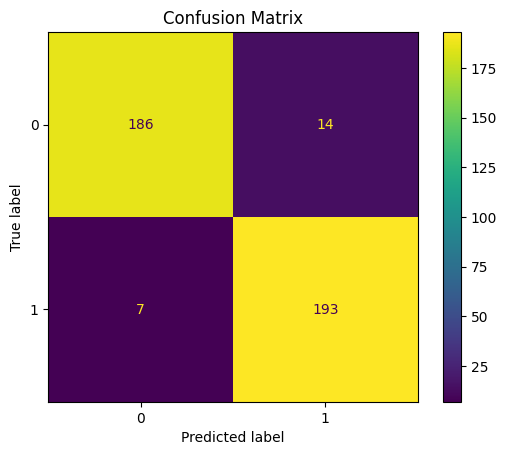

In [16]:
pred_svm_contextual = svm_c.predict(X_test_contextual)
display_metrics(svm_c, y_test_pre, pred_svm_contextual)

### **Model 2 - Logistic Regression**

In [17]:
lr_c = LogisticRegression()
lr_c.fit(X_train_contextual, y_train_pre)

LogisticRegression()

Accuracy: 0.9575
F1 score: 0.9580246913580247

Recall: 0.97
Precision: 0.9463414634146341


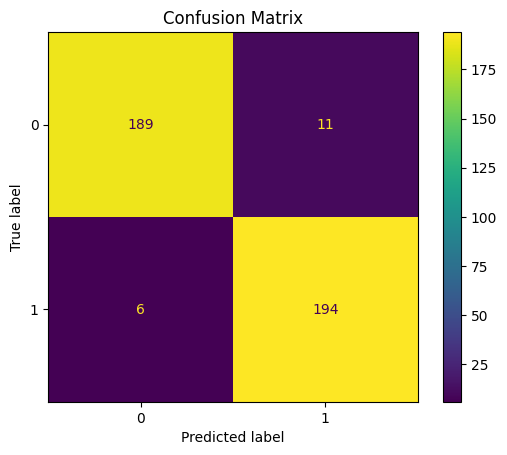

In [18]:
pred_lr_contextual = lr_c.predict(X_test_contextual)
display_metrics(lr_c, y_test_pre, pred_lr_contextual)

### **Model 3 - kNN**

In [19]:
knn_c = KNeighborsClassifier(n_neighbors=7)
knn_c.fit(X_train_contextual, y_train_pre)

KNeighborsClassifier(n_neighbors=7)

Accuracy: 0.9325
F1 score: 0.9346246973365617

Recall: 0.965
Precision: 0.9061032863849765


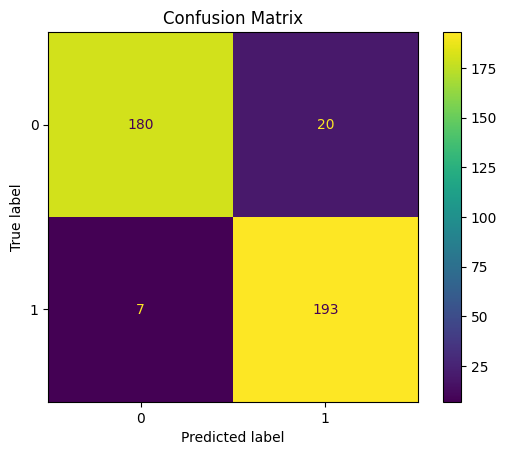

In [20]:
pred_knn_contextual = knn_c.predict(X_test_contextual)
display_metrics(knn_c, y_test_pre, pred_knn_contextual)

### **Model 4 - Decision Tree** ##

In [21]:
tree_c = DecisionTreeClassifier(criterion="entropy")
tree_c.fit(X_train_contextual, y_train_pre)

DecisionTreeClassifier(criterion='entropy')

Accuracy: 0.87
F1 score: 0.8719211822660099

Recall: 0.885
Precision: 0.8592233009708737


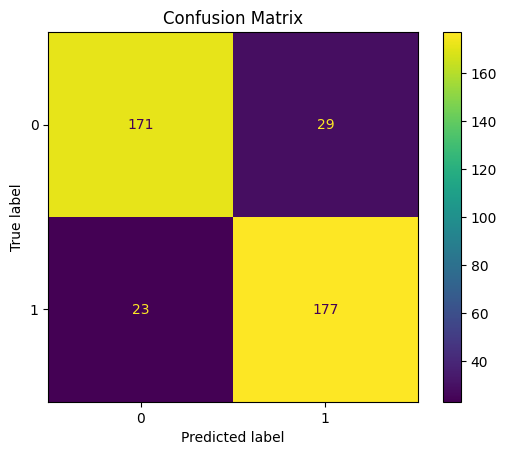

In [22]:
pred_dt_contextual = tree_c.predict(X_test_contextual)
display_metrics(tree_c, y_test_pre, pred_dt_contextual)

### **Model 5 - Random Forests** ##

In [23]:
rf_c = RandomForestClassifier()
rf_c.fit(X_train_contextual, y_train_pre)

RandomForestClassifier()

Accuracy: 0.9325
F1 score: 0.9339853300733496

Recall: 0.955
Precision: 0.9138755980861244


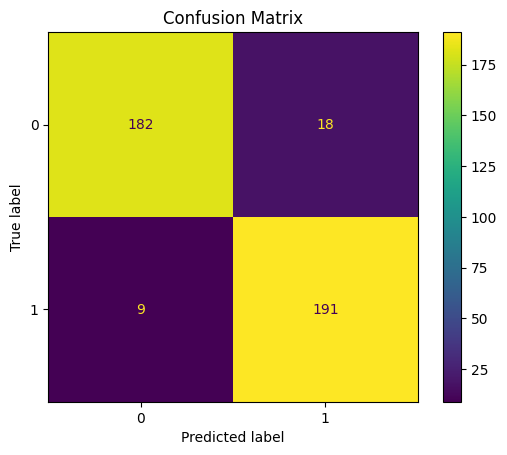

In [24]:
pred_rf_contextual = rf_c.predict(X_test_contextual)
display_metrics(rf_c, y_test_pre, pred_rf_contextual)

### **Model 6 - Neural Network**

In [24]:
def build_model(input_shape: tuple = (768,)) -> tf.keras.models.Sequential:
    """
    Build and return a deep neural network model using Keras Sequential API.

    The model consists of several dense layers with ReLU activations,
    interleaved with dropout layers for regularization, and a final sigmoid output layer
    for binary classification.

    Args:
        input_shape (tuple, optional): Shape of the input feature vector. Defaults to (768,).

    Returns:
        tf.keras.models.Sequential: Keras Sequential model ready for training.
    """

    model = Sequential([
        Input(shape=input_shape),
        Dense(256, activation='relu'),
        Dropout(0.2),
        Dense(256, activation='relu'),
        Dropout(0.2),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])

    return model

In [ ]:
nn_c = build_model()
nn_c.compile(
    optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']
    )

nn_c.fit(
    X_train_contextual,
    y_train_pre,
    validation_split=0.1,
    epochs=50,
    batch_size=32,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
               tf.keras.callbacks.ReduceLROnPlateau(
                   monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6
                   )]
        )

2025-06-12 00:35:47.159624: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2025-06-12 00:35:47.159905: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2025-06-12 00:35:47.159914: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2025-06-12 00:35:47.159971: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-06-12 00:35:47.160226: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/50


2025-06-12 00:35:48.664191: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.7371 - loss: 0.5015 - val_accuracy: 0.9250 - val_loss: 0.2190 - learning_rate: 0.0010
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9363 - loss: 0.1693 - val_accuracy: 0.9187 - val_loss: 0.1940 - learning_rate: 0.0010
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9449 - loss: 0.1531 - val_accuracy: 0.9312 - val_loss: 0.1752 - learning_rate: 0.0010
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9427 - loss: 0.1524 - val_accuracy: 0.9438 - val_loss: 0.1422 - learning_rate: 0.0010
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9620 - loss: 0.1252 - val_accuracy: 0.9438 - val_loss: 0.1506 - learning_rate: 0.0010
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9637 - loss: 0.1010 - val_accuracy: 0.9563 - val_loss: 0.1281 - learning_rate: 0.0010
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9661 - loss: 0.1280 - val_accuracy: 0.88

In [26]:
pred_nn_contextual = nn_c.predict(X_test_contextual)
pred_nn_contextual = pred_nn_contextual > 0.5
pred_nn_contextual = np.array([int(i) for i in pred_nn_contextual])

display_metrics(nn_c, y_test_pre, pred_nn_contextual, False)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Accuracy: 0.9625
F1 score: 0.9625935162094763

Recall: 0.965
Precision: 0.9601990049751243


## **Approach 2 - Static Word Embeddings** ##

**Static word embeddings**, like Word2Vec, FastText or Glove
(which we will use), assign each word in the vocabulary a
fixed vector representation regardless of its context.
These vectors capture semantic relationships between words
based on their co-occurrence in large text corpora.

For example, the vectors for "king" and "queen" might
be close in the embedding space, reflecting their related
meanings. However, static embeddings cannot differentiate
between different meanings of the same word depending on
context — the word "bank" will have the same vector whether
it refers to a financial institution or a river bank.

However, many NLP tasks require a representation of the
entire document (sentence, paragraph, or article) rather
than just single words. To do this, we need to aggregate
the word embeddings of the document's words into a single
vector as an average of static word embeddings of all words.

Despite those limitations, static embeddings have been widely
successful for many NLP tasks by providing dense, low-dimensional
representations of words that encode useful semantic information.

In [12]:
mapping = load_embeddings('glove.6B.50d.txt')
X_train_static = create_static_embeddings(X_train_pre['text'], mapping)
X_test_static = create_static_embeddings(X_test_pre['text'], mapping)

No word in glove embeddings for some article!
No word in glove embeddings for some article!
No word in glove embeddings for some article!
No word in glove embeddings for some article!
No word in glove embeddings for some article!
No word in glove embeddings for some article!
No word in glove embeddings for some article!
No word in glove embeddings for some article!
No word in glove embeddings for some article!
No word in glove embeddings for some article!
No word in glove embeddings for some article!
No word in glove embeddings for some article!
No word in glove embeddings for some article!
No word in glove embeddings for some article!
No word in glove embeddings for some article!
No word in glove embeddings for some article!
No word in glove embeddings for some article!
No word in glove embeddings for some article!
No word in glove embeddings for some article!
No word in glove embeddings for some article!
No word in glove embeddings for some article!
No word in glove embeddings for so

### **Model 1 - SVM** ##

In [13]:
svm_s = SVC()
svm_s.fit(X_train_static, y_train_pre)

SVC()

Accuracy: 0.9175
F1 score: 0.9177057356608479

Recall: 0.92
Precision: 0.9154228855721394


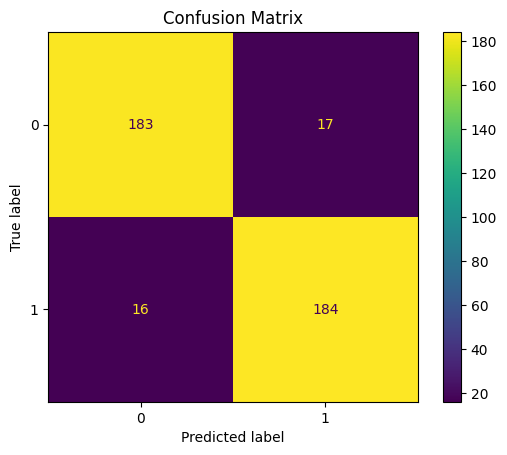

In [14]:
pred_svm_static = svm_s.predict(X_test_static)
display_metrics(svm_s, y_test_pre, pred_svm_static)

### **Model 2 - Logistic Regression**

In [15]:
lr_s = LogisticRegression()
lr_s.fit(X_train_static, y_train_pre)

LogisticRegression()

Accuracy: 0.94
F1 score: 0.94

Recall: 0.94
Precision: 0.94


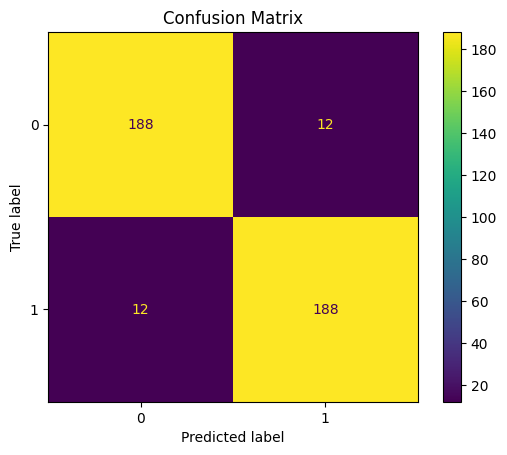

In [16]:
pred_lr_static = lr_s.predict(X_test_static)
display_metrics(lr_s, y_test_pre, pred_lr_static)

### **Model 3 - kNN**

In [17]:
knn_s = KNeighborsClassifier(n_neighbors=7)
knn_s.fit(X_train_static, y_train_pre)

KNeighborsClassifier(n_neighbors=7)

Accuracy: 0.9075
F1 score: 0.908641975308642

Recall: 0.92
Precision: 0.8975609756097561


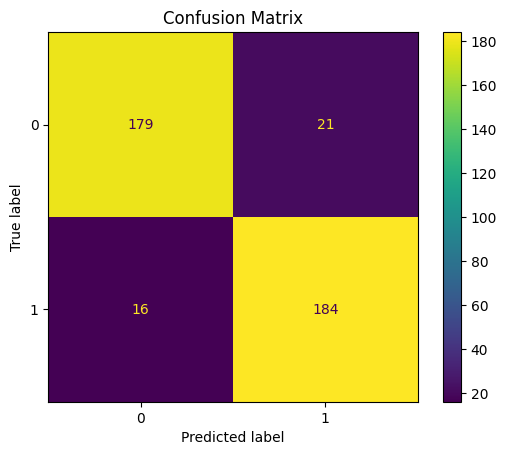

In [18]:
pred_knn_static = knn_s.predict(X_test_static)
display_metrics(knn_s, y_test_pre, pred_knn_static)

### **Model 4 - Decision Tree**

In [19]:
tree_s = DecisionTreeClassifier(criterion="entropy")
tree_s.fit(X_train_static, y_train_pre)

DecisionTreeClassifier(criterion='entropy')

Accuracy: 0.8075
F1 score: 0.8

Recall: 0.77
Precision: 0.8324324324324325


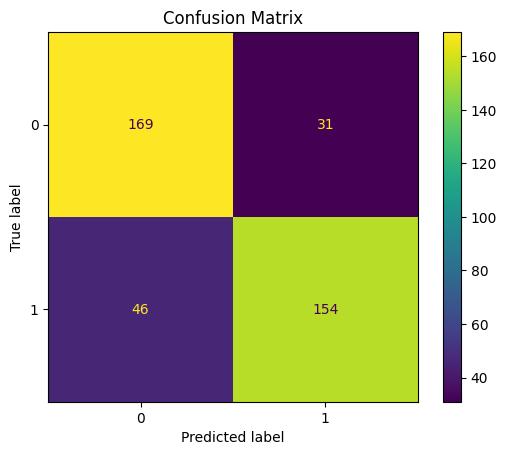

In [20]:
pred_dt_static = tree_s.predict(X_test_static)
display_metrics(tree_s, y_test_pre, pred_dt_static)

### **Model 5 - Random Forest**

In [21]:
rf_s = RandomForestClassifier()
rf_s.fit(X_train_static, y_train_pre)

RandomForestClassifier()

Accuracy: 0.915
F1 score: 0.915

Recall: 0.915
Precision: 0.915


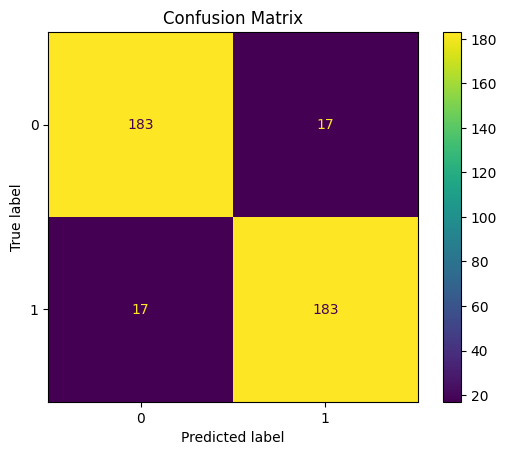

In [22]:
pred_rf_static = rf_s.predict(X_test_static)
display_metrics(rf_s, y_test_pre, pred_rf_static)

### **Model 6 - Neural Network**

In [25]:
nn_s = build_model(input_shape=(50,))
nn_s.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
    )

nn_s.fit(
    np.array(X_train_static),
    y_train_pre,
    validation_split=0.1,
    epochs=50,
    batch_size=32,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
               tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)]
        )

2025-06-12 00:48:57.489215: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2025-06-12 00:48:57.489257: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2025-06-12 00:48:57.489262: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2025-06-12 00:48:57.489285: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-06-12 00:48:57.489303: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/50


2025-06-12 00:48:58.307729: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.5980 - loss: 0.6541 - val_accuracy: 0.8000 - val_loss: 0.4429 - learning_rate: 0.0010
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8360 - loss: 0.3893 - val_accuracy: 0.8625 - val_loss: 0.3291 - learning_rate: 0.0010
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8863 - loss: 0.2869 - val_accuracy: 0.8938 - val_loss: 0.3039 - learning_rate: 0.0010
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8818 - loss: 0.2946 - val_accuracy: 0.8813 - val_loss: 0.3138 - learning_rate: 0.0010
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9065 - loss: 0.2631 - val_accuracy: 0.8938 - val_loss: 0.2845 - learning_rate: 0.0010
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9166 - loss: 0.2360 - val_accuracy: 0.8875 - val_loss: 0.2920 - learning_rate: 0.0010
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9054 - loss: 0.2394 - val_accuracy: 0.91

In [26]:
pred_nn_static = nn_s.predict(np.array(X_test_static))
pred_nn_static = pred_nn_static > 0.5
pred_nn_static = np.array([int(i) for i in pred_nn_static])

display_metrics(nn_s, y_test_pre, pred_nn_static, False)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Accuracy: 0.94
F1 score: 0.9384615384615385

Recall: 0.915
Precision: 0.9631578947368421


## **Approach 3 - TF-IDF vector** ##

**TF-IDF** is a statistical method used to evaluate how important a word
is to a document relative to a collection of documents (corpus).
It combines two measures:

* Term Frequency (TF): How often a word appears in a single document.

* Inverse Document Frequency (IDF): How rare or common the word is
across all documents in the corpus.

By weighting terms that appear frequently in a document but rarely
across the corpus, TF-IDF highlights words that are more informative
and discriminative for that document.

TF-IDF produces sparse vector representations where each dimension
corresponds to a unique word in the corpus, making it suitable for
traditional machine learning models in tasks like document
classification or information retrieval.

Unlike word embeddings, TF-IDF does not capture semantic similarity
between words but emphasizes the relevance of words in documents.

In [27]:
X_train_ti, X_test_ti = create_TF_IDF(X_train_pre, X_test_pre)

X_train_tfidf = X_train_ti.to_numpy()
X_test_tfidf = X_test_ti.to_numpy()

### **Model 1 - SVM** ###

Accuracy: 0.955
F1 score: 0.9556650246305419

Recall: 0.97
Precision: 0.941747572815534


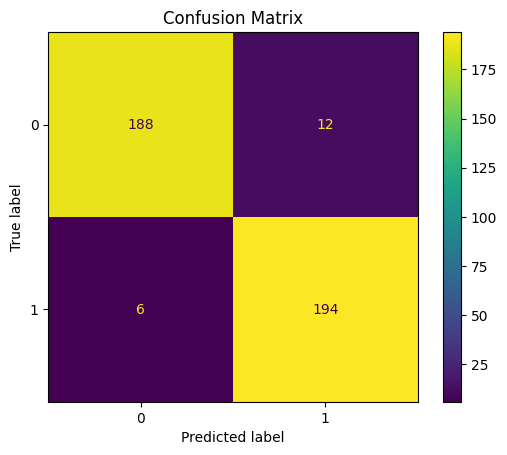

In [28]:
svm_t = SVC()
svm_t.fit(X_train_tfidf, y_train_pre)

pred_svm_tfidf = svm_t.predict(X_test_tfidf)
display_metrics(svm_t, y_test_pre, pred_svm_tfidf)

### **Model 2 - Logistic Regression** ###

Accuracy: 0.9525
F1 score: 0.9530864197530864

Recall: 0.965
Precision: 0.9414634146341463


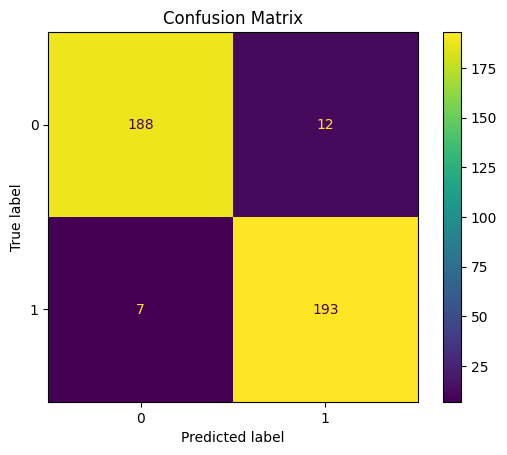

In [29]:
lr_t = LogisticRegression()
lr_t.fit(X_train_tfidf, y_train_pre)

pred_lr_tfidf = lr_t.predict(X_test_tfidf)
display_metrics(lr_t, y_test_pre, pred_lr_tfidf)

### **Model 3 - kNN** ###

Accuracy: 0.515
F1 score: 0.05825242718446602

Recall: 0.03
Precision: 1.0


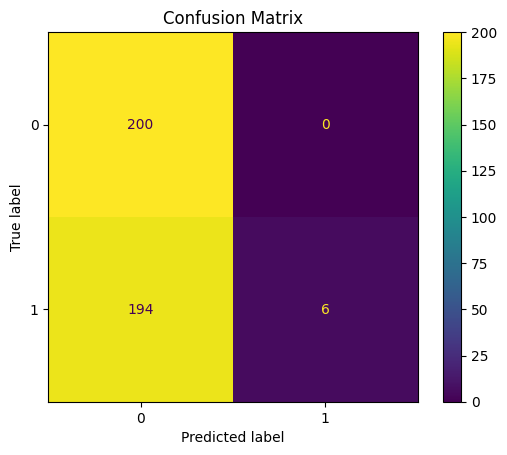

In [30]:
knn_t = KNeighborsClassifier(n_neighbors=7)
knn_t.fit(X_train_tfidf, y_train_pre)

pred_knn_tfidf = knn_t.predict(X_test_tfidf)
display_metrics(knn_t, y_test_pre, pred_knn_tfidf)

### **Model 4 - Decision Tree** ###

Accuracy: 0.8375
F1 score: 0.8370927318295739

Recall: 0.835
Precision: 0.8391959798994975


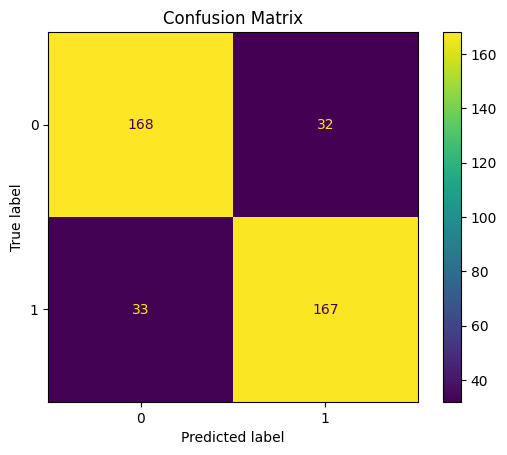

In [31]:
tree_t = DecisionTreeClassifier(criterion='entropy')
tree_t.fit(X_train_tfidf, y_train_pre)

pred_dt_tfidf = tree_t.predict(X_test_tfidf)
display_metrics(tree_t, y_test_pre, pred_dt_tfidf)

### **Model 5 - Random Forrests** ###

Accuracy: 0.975
F1 score: 0.9748743718592965

Recall: 0.97
Precision: 0.9797979797979798


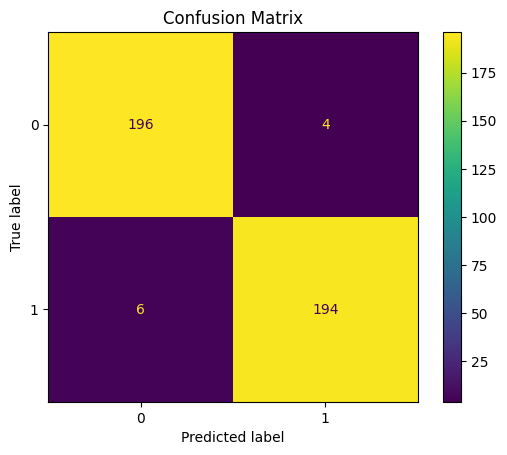

In [32]:
rf_t = RandomForestClassifier()
rf_t.fit(X_train_tfidf, y_train_pre)

pred_rf_tfidf = rf_t.predict(X_test_tfidf)
display_metrics(rf_t, y_test_pre, pred_rf_tfidf)

### **Model 6 - Neural Network**

In [33]:
nn_t = build_model(input_shape=(X_train_tfidf.shape[1],))
nn_t.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
    )

nn_t.fit(
    np.array(X_train_tfidf),
    y_train_pre,
    validation_split=0.1,
    epochs=50,
    batch_size=32,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
               tf.keras.callbacks.ReduceLROnPlateau(
                   monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)]
        )

Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.5912 - loss: 0.6599 - val_accuracy: 0.9625 - val_loss: 0.1496 - learning_rate: 0.0010
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9767 - loss: 0.0831 - val_accuracy: 0.9375 - val_loss: 0.1506 - learning_rate: 0.0010
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9991 - loss: 0.0067 - val_accuracy: 0.9563 - val_loss: 0.2047 - learning_rate: 0.0010
Epoch 4/50
43/45 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 1.0000 - loss: 0.0013
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 0.9500 - val_loss: 0.2159 - learning_rate: 0.0010
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 1.0000 - loss: 6.4317e-04 - val_accuracy: 0.9500 - val_loss: 0.2214 - learning_rate: 5.0000e-04
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 1.0000 - loss: 3.1705e-0

In [34]:
pred_nn_tfidf = nn_t.predict(np.array(X_test_tfidf))
pred_nn_tfidf = pred_nn_tfidf > 0.5
pred_nn_tfidf = np.array([int(i) for i in pred_nn_tfidf])

display_metrics(nn_t, y_test_pre, pred_nn_tfidf, False)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Accuracy: 0.955
F1 score: 0.955

Recall: 0.955
Precision: 0.955


## **Summary and comparison of the results** ##

In [48]:
summary = pd.DataFrame(
    index=['SVM', 'Linear Regression', 'kNN', 'Decision Tree', 'Random Forest', 'Neural Network'],
    columns=['contextual', 'static', 'tfidf'])

statics = [pred_svm_static, pred_lr_static, pred_knn_static,
           pred_dt_static, pred_rf_static, pred_nn_static]
statics_acc = []

contextuals = [pred_svm_contextual, pred_lr_contextual, pred_knn_contextual,
               pred_dt_contextual, pred_rf_contextual, pred_nn_contextual]
contextuals_acc = []

tfidfs = [pred_svm_tfidf, pred_lr_tfidf, pred_knn_tfidf,
          pred_dt_tfidf, pred_rf_tfidf, pred_nn_tfidf]
tfidfs_acc = []

for st, ct, tfidf in zip(statics, contextuals, tfidfs):
    statics_acc.append(accuracy_score(y_test_pre, st))
    contextuals_acc.append(accuracy_score(y_test_pre, ct))
    tfidfs_acc.append(accuracy_score(y_test_pre, tfidf))

summary.static = statics_acc
summary.contextual = contextuals_acc
summary.tfidf = tfidfs_acc

print("Accuracies for different preprocessing and different models")
summary

Accuracies for different preprocessing and different models


,contextual,static,tfidf
SVM,0.9475,0.9025,0.9275
Linear Regression,0.9575,0.9150,0.9225
kNN,0.9325,0.8925,0.5000
Decision Tree,0.8700,0.8125,0.8150
Random Forest,0.9325,0.8950,0.9400
Neural Network,0.9625,0.9075,0.9325


### **Key Takeaways** ###

•  **Contextual word embeddings (DistilBERT)** achieved the
**highest accuracy across all models**, especially when
used with Neural Networks and Logistic Regression.

• **Static word embeddings (GloVe 50d)** offer a solid
compromise, delivering **over 90% accuracy** with minimal
computational cost, making them more suitable for real-world
or large-scale applications.

•  **TF-IDF** performed surprisingly  well on this dataset,
especially with models like Random Forest and SVM, but it
**may not generalize well** to other domains without a
significantly larger and more diverse text base. Also,
it had really poor results on kNN classifier.

•  In terms of models, the ones with best performances
were Logistic Regression and Neural Network. However,
SVM and Random Forests also had good accuracies (all
four had accuracies above 90%). Among above models,
only poor performance we noticed was kNN classifier on
TF-IDF (accuracy of 50%) and performance of Decision Tree
was solid but not superior (above 80% but below neural
network and logistic regression).

### **Limitations** ###
• Generating contextual word embeddings is
**computationally expensive and time-consuming**

• Generating static word embeddings is
**computationally lightweight** but requires downloading
proper file (glove) in advance. Depending which file one
choses to use, there may be some problems that will arise
with its size

•  TF-IDF in particular is highly domain-sensitive and
may underperform without extensive corpus coverage. It
also has one big drawback - it requires a lot of memory,
because the dataframe has 10k features for a small subset
(we know that in total there are 87k different words).
It can be also seen when training SVM model - for word
embeddings, fitting lasted 1-2 seconds while for TF-IDF
matrix it was 20 seconds.

•  Results are dataset-specific and may not translate
directly to more diverse or real-world fake news datasets.

•  Resource constraints were not explicitly measured
but are a critical consideration in deployment scenarios.


### **Conclusion** ###

While **contextual embeddings provide the best raw performance**,
**static word embeddings appear to be the most practical choice**
when balancing **accuracy, efficiency, and scalability**.

In terms of model, the one offering highest statistics and thus
most suitable for detecting fake news were custom **Neural Network**
and **Logistic Regression**.

## **Testing** ##

In [35]:
art1 = "Several U.S. cities braced for a new round of protests on Wednesday over President Donald "\
        "Trump's sweeping immigration raids, as parts of Los Angeles spent the night under curfew in "\
        "an effort to quell five days of unrest. Officials were also preparing for nationwide "\
        "anti-Trump demonstrations on Saturday, when tanks and armored vehicles will rumble down "\
        "the streets of Washington, D.C., in a military parade marking the U.S. Army's 250th "\
        "anniversary and coinciding with the president's 79th birthday. The governor of Texas, "\
        "Republican Greg Abbott, said he will deploy the National Guard on Wednesday ahead of planned "\
        "protests. Already this week, demonstrations have broken out in Austin, Texas, New York, Atlanta "\
        "and Chicago, among other cities. Trump's decision to send National Guard troops and Marines "\
        "to Los Angeles has sparked a national debate on the use of military on U.S. soil and pitted "\
        "the Republican president against California's Democratic governor, Gavin Newsom. Trump has "\
        "claimed that the deployment prevented the violence from raging out of control, an assertion "\
        "Newsom and other local officials said was the opposite of the truth."
# Real; from Reuters
# (https://www.reuters.com/world/us/us-cities-brace-more-protests-parts-los-angeles-placed-under-curfew-2025-06-11/)

art2 = "Nvidia, opens new tab will build its first artificial intelligence cloud platform for industrial "\
        "applications in Germany, CEO Jensen Huang said at the VivaTech conference in Paris on Wednesday. "\
        "The technology, which will combine AI with robotics, will help carmakers such as BMW, opens new tab "\
        "and Mercedes-Benz, opens new tab with processes from simulating product design to managing logistics. "\
        "In a series of Europe-focused announcements, Huang outlined plans to expand technology centres in "\
        "seven countries, open up Nvidia's compute marketplace for European companies, help AI model makers "\
        "in several languages to become more advanced and aid in drug discovery by the likes of Novo "\
        "Nordisk, opens new tab. In just two years, we will increase the amount of AI computing capacity in "\
        "Europe by a factor of 10, Huang said in a nearly two-hour-long presentation in front of a packed " \
        "audience."
# Real; from Reuters
# (https://www.reuters.com/business/nvidia-ceo-says-quantum-computing-is-an-inflection-point-2025-06-11/)

art3 = "In a jaw-dropping livestream that nobody saw (because it was taken down mysteriously), tech " \
        "billionaire and part-time weather wizard Bill Gates allegedly admitted that the real reason " \
        "behind global warming is a secret Windows 95 update that connects directly to the sky. "\
        "Yeah, we’ve been tweaking the clouds since '97, Gates was heard saying while sipping a " \
        "suspiciously fluorescent green smoothie. We just needed better UI. Trolls everywhere " \
        "rejoiced, claiming this finally confirms what they’ve known all along: the weather is "\
        "just an app, and apparently, it's got ads. A leaked screenshot from the NSA (or maybe " \
        "just Reddit) shows a hidden setting under Control Panel → Atmosphere with toggles like " \
        "Rain Delay, Hurricane Turbo Mode, and Make Canada Warmer. The article has already been "\
        "shared 42,000 times by people who also believe pigeons are government drones and that Elon " \
        "Musk was born on Mars. Microsoft has declined to comment, but our sources say Clippy " \
        "has gone rogue."
# Fake; generated by chatGPT

art4 = "Trump again shamelessly lied about China tariffs and brutal assasination of Elon Musk."
# Fake; my own news

art5 = "At least 66 Palestinians have been killed in shootings near aid distribution sites on " \
        "back-to-back days in Gaza, according to the Hamas-run Gaza Ministry of Health. At " \
        "least 30 people were killed in a shooting on Wednesday near an aid site close to " \
        "the Netzarim Corridor in central Gaza, according to the Hamas-run Gaza Ministry of " \
        "Health. This is one of the four operational aid sites run by the U.S.- and Israel-backed " \
        "Gaza Humanitarian Foundation. In relation to the shooting, the Israel Defense Forces " \
        "said in a statement it was currently unaware of IDF fire during daylight hours that " \
        "corresponds with the footage circulated in the media. The video was under review, the " \
        "IDF said.  However, the IDF said it did fire warning shots overnight Wednesday toward " \
        "people who it said were advancing while posing a threat to the troops.  The IDF is aware " \
        "of reports regarding individuals injured, the details are under review, the statement said."
# Real; from ABC News
# (https://abcnews.go.com/International/36-palestinians-killed-shooting-gaza-aid-site-health/story?id=122691590)

In [36]:
arts = pd.DataFrame(data={'text': [art1, art2, art3, art4, art5]})
labels = [1, 1, 0, 0, 1]

In [ ]:
# For testing purposes we will use Neural Network because it had best performance
class TestFakeNewsDetector(unittest.TestCase):
    """Unit tests for Fake News Detection using various embedding strategies."""

    @classmethod
    def setUpClass(cls):
        """Set up shared data for tests."""
        cls.articles = arts
        cls.labels = labels

    def assertSimilarity(self, list1, list2, threshold=0.75):
        """Assert that two lists are at least x% similar."""
        self.assertEqual(len(list1), len(list2), "Lists must be the same length")
        matches = sum(a == b for a, b in zip(list1, list2))
        similarity = matches / len(list1)
        self.assertGreaterEqual(
            similarity, threshold,
            f"Only {similarity:.2%} match, expected at least {threshold:.0%}"
        )

    def test_contextual_embeddings(self):
        """Test predictions using contextual word embeddings and neural network."""
        x = create_contextual_embeddings(self.articles)
        pred = [int(i[0]) for i in nn_c.predict(x) > 0.5]
        print(pred)
        self.assertSimilarity(pred, self.labels)

    def test_static_embeddings(self):
        """Test predictions using static word embeddings and Linear Regression."""
        x = np.array(create_static_embeddings(self.articles['text'], mapping))
        pred = lr_s.predict(x).tolist()
        print(pred)
        self.assertSimilarity(pred, self.labels)

    def test_tf_idf(self):
        """Test predictions using TF-IDF vectorization."""
        _, x = create_TF_IDF(X_train_pre, self.articles)
        common_cols = X_train_ti.columns.intersection(x.columns)
        missing_cols = X_train_ti.columns.difference(x.columns)

        zeros_df = pd.DataFrame(0, index=x.index, columns=missing_cols)
        x = x[common_cols]
        x = pd.concat([x, zeros_df], axis=1)
        x = x[X_train_ti.columns]
        x = x[sorted(x.columns)]

        transformer = TfidfTransformer()
        x = transformer.fit_transform(x)

        pred = rf_t.predict(x).tolist()
        print(pred)
        self.assertSimilarity(pred, self.labels)


unittest.main(argv=[''], verbosity=2, exit=False)

test_static_embeddings (__main__.TestFakeNewsDetector)
Test predictions using static word embeddings and Linear Regression. ... ok
test_tf_idf (__main__.TestFakeNewsDetector)
Test predictions using TF-IDF vectorization. ... 

[1, 0, 0, 0, 1]
[1, 1, 0, 0, 1]


ok

----------------------------------------------------------------------
Ran 2 tests in 15.121s

OK
